# Accessibility to public transport

In [1]:
# If using colab
# Takes around 2-3 min
# !pip install "UrbanAccessAnalyzer[osm,plot,h3] @ git+https://github.com/CityScope/UrbanAccessAnalyzer.git"
# !pip install "pyGTFSHandler[osm,plot] @ git+https://github.com/CityScope/pyGTFSHandler.git"
# !pip install matplotlib mapclassify folium
# !apt-get install -y osmium-tool


# Restart notebook after installing this if needed

In [2]:
import sys 
sys.path.append('/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler')

In [3]:
import os
from datetime import datetime, date, timedelta, time
import pandas as pd
import polars as pl
import geopandas as gpd
from pathlib import Path
import zipfile

import osmnx as ox

import matplotlib.pyplot as plt

import UrbanAccessAnalyzer.isochrones as isochrones
import UrbanAccessAnalyzer.graph_processing as graph_processing
import UrbanAccessAnalyzer.osm as osm
import UrbanAccessAnalyzer.utils as utils
import UrbanAccessAnalyzer.h3_utils as h3_utils
import UrbanAccessAnalyzer.population as population
import UrbanAccessAnalyzer.quality as quality_utils
import UrbanAccessAnalyzer.plot_helpers as plot_helpers

from pyGTFSHandler.feed import Feed
from pyGTFSHandler.downloaders.mobility_database import MobilityDatabaseClient
import pyGTFSHandler.plot_helper as plot_helper
import pyGTFSHandler.gtfs_checker as gtfs_checker
import pyGTFSHandler.processing_helper as processing_helper

import zipfile
import numpy as np

## 1 Inputs

General

In [4]:
city_name = "Parla, Spain"
download_buffer = 1000 # Download area should be larger than the aoi by 'download_buffer' meters
# It should be max(distance_steps) but there is the risk of downloading an area that is too large
min_edge_length = 30 # Simplify street graph to avoid edges of less than 'min_edge_length'
h3_resolution = 10 # If you want results in h3 this is the output h3 resolution

Public transport timetables

In [5]:
stop_id = "parent_station" # Use the stop groups created with arg stop_group_distance in Feed to group neraby stops into one
# You could choose 'stop_id' too
stop_group_distance = 100 # Group near stops (less than x meters apart). This creates or updates the parent_station column
start_date = datetime.today()
end_date = start_date + timedelta(days=30)
date_type='businessday' # Could be something like 'holiday', 'businessday', 'non_businessday', or 'monday' to only consider some dates from the range.
start_time = time(hour=8)
end_time = time(hour=20) 
simplified_route_type_mapping = {
    'bus':'all',
    'tram':[0,1,2,4,5,6,7],
    'rail':[1,2]
}
# -1 - other/nodata
# 0 - tram 
# 1 - subway 
# 2 - rail 
# 3 - bus
# 4 - ferry 
# 5 - cable car 
# 6 - gondola 
# 7 - funicular

Accessbility parameters

In [6]:
interval_elasticity = 0.3 
walk_elasticity = 0.2 
speed_elasticity = 0.2 
mode_factor = { # The stop grade will be multiplied by this factor
    'bus':1, # Use the same keys as simplified_route_type_mapping
    'tram':1,
    'rail':1
}
n_accessibility_grades = 10 # 10 grades from 0 to 1
max_interval = 1440 # in min
max_walk_distance = 2000 # in m
max_speed = 150 # in km/h

min_interval = 5 # in min 
min_walk_distance = 100 # in m
min_speed = 5 # in km/h

best_quality = {
    'interval':5,
    'mode':'rail',
    'speed':30,
    'distance':100,
}
worst_quality = {
    'interval':720,
    'mode':'bus',
    'speed':10,
    'distance':2000,
}

### Results folder

Where do you want to save the results?

In [7]:
results_path = os.path.normpath("output")

gtfs_path = os.path.join(results_path,"gtfs_files") 

city_filename = utils.sanitize_filename(city_name)
city_results_path = os.path.join(results_path,city_filename)

osm_xml_file = os.path.normpath(city_results_path+f"/streets.osm")
streets_graph_path = os.path.normpath(city_results_path+f"/streets.graphml")
streets_path = os.path.normpath(city_results_path+f"/streets.gpkg")
accessibility_streets_path = os.path.normpath(city_results_path+f"/accessibility_streets.gpkg")
population_results_path = os.path.normpath(city_results_path+f"/population.gpkg")

In [8]:
os.makedirs(results_path,exist_ok=True)
os.makedirs(gtfs_path,exist_ok=True)
os.makedirs(city_results_path,exist_ok=True)

### Area of interest
**Area of interest (aoi)**: Polygon. Geographic area where you want to run your analysis.

**Option 1:** From the internet with the city name

In [9]:
aoi = utils.get_city_geometry(city_name)
geo_suggestions = utils.get_geographic_suggestions_from_string(city_name,user_agent="app")
geo_suggestions

{'country_codes': ['ES'],
 'subdivision_names': ['Community of Madrid'],
 'municipalities': ['Parla']}

**Option 2:** Load your own file

In [10]:
# Geographic file (.gpkg, .geojson or .shp)

# aoi = gpd.read_file("")

In [11]:
# csv file with lat/lon columns in geographic coordinates


# df = pd.read_csv("")


# # Create geometry from lon/lat columns
# geometry = gpd.points_from_xy(df["lon"], df["lat"]) # Change column names if needed
# # Convert to GeoDataFrame
# aoi = gpd.GeoDataFrame(
#     df,
#     geometry=geometry,
#     crs="EPSG:4326"  # geographic crs Change if needed
# )

# # OR Parse WKT geometry column
# df["geometry"] = df["geometry"].apply(wkt.loads) # change to match your geometry column name
# # Convert to GeoDataFrame
# aoi = gpd.GeoDataFrame(
#     df,
#     geometry="geometry",
#     crs="EPSG:4326"  # set to whatever CRS the WKT represents
# )

Use UTM coords and create aoi_download with a buffer of X meters. To avoid boundary effects streets and pois should be downloaded for a larger area.

In [12]:
aoi = gpd.GeoDataFrame(geometry=[aoi.union_all()],crs=aoi.crs) # Ensure there is only one polygon
aoi = aoi.to_crs(aoi.estimate_utm_crs()) # Convert to utm

aoi_download = aoi.buffer(download_buffer) # Area to do streets and poi requests 

### Public transport data

**Option 1** Download GTFS feeds worldwide

With the MobilityData API

This is the organization responsible for the GTFS standard and has info from almost all the world

In [13]:
# Request your refresh token here: https://mobilitydatabase.org/ 
refresh_token = 'AMf-vByYiwMAni1pw6yTpwgwwYFc8HR4y0zUKZGPT4sjJ0wUrIXOfVxF1KotRIvEgAseaaNheL8YczJiCILb6o2PUh-8zjA-qQURzEc8tELlwFiDopMoqJnkDf13AqNaGGnnzTDmYM20AWEquUxcYFAB8Q3e5rI2DcTBSQuiUdHL8bi48xmUJk3tayHpnoicoppi_evDcWYODwOJFcwnta3K7f718w7R2JRM0zDEOYw7nI7thrQa9462BENdpv8zv8mEbBssEa189k6YcV__sQAZlng2EcsCGA'
api = MobilityDatabaseClient(refresh_token)

2026-01-31 20:26:50,227 - INFO - Obtaining or refreshing access token...
2026-01-31 20:26:52,178 - INFO - Access token obtained successfully.


Find Feeds on the API

In [14]:
feeds = api.search_gtfs_feeds(
    country_code=geo_suggestions['country_codes'],
    subdivision_name=geo_suggestions['subdivision_names'], # This info is not always in the feeds metadata. Comment this if you did not find all feeds.
    municipality=geo_suggestions['municipalities'], # This info is not always in the feeds metadata. Comment this if you did not find all feeds.
    is_official=None, # Set to True if you only want official feeds
    #aoi=aoi, # You could comment the rest of search args and use only aoi but for now the API seems to not do this very well as the metadata is often wrong.
)

for f in feeds:
    print(f['provider'])

ALSA buses
Consorcio Regional de Transportes de Madrid
Consorcio Regional de Transportes de Madrid CRTM Commuter Network (Red de Cercanías)
Consorcio Regional de Transportes de Madrid CRTM Intercity Buses (Madrid Intercity Buses)
Consorcio Regional de Transportes de Madrid CRTM Light Rail Network (Red de Metro Ligero)
Consorcio Regional de Transportes de Madrid CRTM Madrid City Bus (Autobús urbano de Madrid)
Renfe Cercanias
Renfe commuter trains (Cercanias)
Samar Buses


Download current active files

In [15]:
file_paths = api.download_feeds(
    feeds=feeds,
    download_folder=gtfs_path,
    overwrite=False
)

2026-01-31 20:26:54,458 - INFO - Successfully downloaded 9 feeds.


**Option 2** Load your own gtfs files

In [16]:
# file_paths = [
#     os.path.normpath("folder/gtfs_file.zip"),
# ]

In [17]:
# # Unzip if needed
# unzipped_paths = []
# for p in file_paths:
#     path = Path(p)

#     # Check if it's a zip file
#     if path.is_file() and path.suffix.lower() == ".zip":
#         extract_dir = path.with_suffix("")  # same name, no .zip

#         # Extract only if folder doesn't exist
#         if not extract_dir.exists():
#             with zipfile.ZipFile(path, "r") as zip_ref:
#                 zip_ref.extractall(extract_dir)

#         unzipped_paths.append(str(extract_dir))
#     else:
#         unzipped_paths.append(str(path))

# file_paths = unzipped_paths

**Extra:** Properly check all gtfs files for validity

This takes a few minutes. If you skip this step minor validation without logs will be carried out when loading any gtfs.

In [18]:
# # Check and fix the gtfs files (This takes a few minutes). Set check_files = False in Feed to load faster

# new_gtfs_path = os.path.join(results_path,"revised_gtfs_files") 
# os.makedirs(new_gtfs_path)

# new_file_paths = []
# for f in file_paths:
#     filename = os.path.splitext(os.path.basename(f))[0]
#     if os.path.isdir(os.path.join(new_gtfs_path,filename)):
#         new_file_paths.append(os.path.join(new_gtfs_path,filename))
#     else:
#         new_file_paths.append(gtfs_checker.preprocess_gtfs(f,new_gtfs_path))

# file_paths = new_file_paths

## 2 Grading functions

Define from the elasticity values provided in the input exponential functions that return a value from 0 to 1 to represent the quality of every parameter. For mode return directly the corresponding parameter.

The final quality will be the product of the qualities of interval, mode, speed and distance. 

In [19]:
def interval_quality(interval):
    return quality_utils.elasticity_based_quality(interval,min_interval,-interval_elasticity)

def walk_quality(distance):
    return quality_utils.elasticity_based_quality(distance,min_walk_distance,-walk_elasticity)

def speed_quality(speed):
    return quality_utils.elasticity_based_quality(speed,max_speed,speed_elasticity)

def mode_quality(mode):
    if isinstance(mode, str):
        # single string
        return mode_factor[mode]
    else:
        # convert to np.array if list
        mode_arr = np.array(mode)
        # vectorized lookup
        vectorized_lookup = np.vectorize(lambda m: mode_factor[m])
        return vectorized_lookup(mode_arr)

def stop_quality(interval,mode,speed):
    return (
        interval_quality(interval) * 
        mode_quality(mode) *
        speed_quality(speed)
    )

stop_quality = quality_utils.calibrate_quality_func(
    stop_quality,
    min_quality=1/n_accessibility_grades,
    max_quality=1,
    min_point=(worst_quality['interval'],worst_quality['mode'],worst_quality['speed']),
    max_point=(best_quality['interval'],best_quality['mode'],best_quality['speed']),
)

def quality(interval,mode,speed,distance):
    return (
        stop_quality(interval,mode,speed) * 
        walk_quality(distance)
    )

quality = quality_utils.calibrate_quality_func(
    quality,
    min_quality=1/n_accessibility_grades,
    max_quality=1,
    min_point=(worst_quality['interval'],worst_quality['mode'],worst_quality['speed'],worst_quality['distance']),
    max_point=(best_quality['interval'],best_quality['mode'],best_quality['speed'],best_quality['distance']),
)

In [20]:
interval_grid, mode_grid, speed_grid, distance_grid = quality_utils.build_adaptive_grids(
    quality,
    variables=[
        [min_interval, max_interval],
        list(simplified_route_type_mapping.keys()),
        [min_speed, max_speed],
        [min_walk_distance, max_walk_distance],
    ],
    delta=1/n_accessibility_grades
)
speed_grid = [0,*speed_grid] # Add 0 as the first speed in the speed grid
# This avoids creating a grid at very low speeds but we still include all of them with the speed 0

## 3 Public transport timetables

### 3.1 Create the gtfs object

This will do:

- Load all .txt files of all gtfs folders given.
- Select only the stops from stops.txt inside the area of interest.
- Crop all trips in stop_times.txt with the stops inside the aoi + 1 more stop.
- Check the stop_sequence in stop_times.txt.
- Deal correctly with trips starting on one day and ending in the following day: hours always in 0-24 range but those trips are marked as next_day True. New service_ids are created to deal with that.
- If the file has frequencies.txt this is processed too dealing with the next day problem.
- If departure or arrival times are empty they get filled.
- A shape direction col is computed as the mean heading of the vector between stop coordinates to mean of the remainning stops coordinates.
- GTFS shapes are for now computed from the stop coordinates.

In [21]:
gtfs = Feed(
    file_paths,
    aoi=aoi,
    stop_group_distance=stop_group_distance, # Group stops into one that are less than x meters apart. This creates or updates the parent_station column
    start_date=start_date,
    end_date=end_date,
)

### 3.2 Service Intensity

This is the number of vehicles that arrive at each stop every day multiplied by the number of stops:

$\text{Service Intensity} = (\text{Number of vehicles per stop}) \times (\text{Number of stops})$

/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/pyGTFSHandler/utils.py:282: UserWarning: Fuzzy match used for region 'Comunidad de Madrid' -> 'Madrid, Comunidad de'
  warnings.warn(f"Fuzzy match used for region '{region_name}' -> '{match}'")


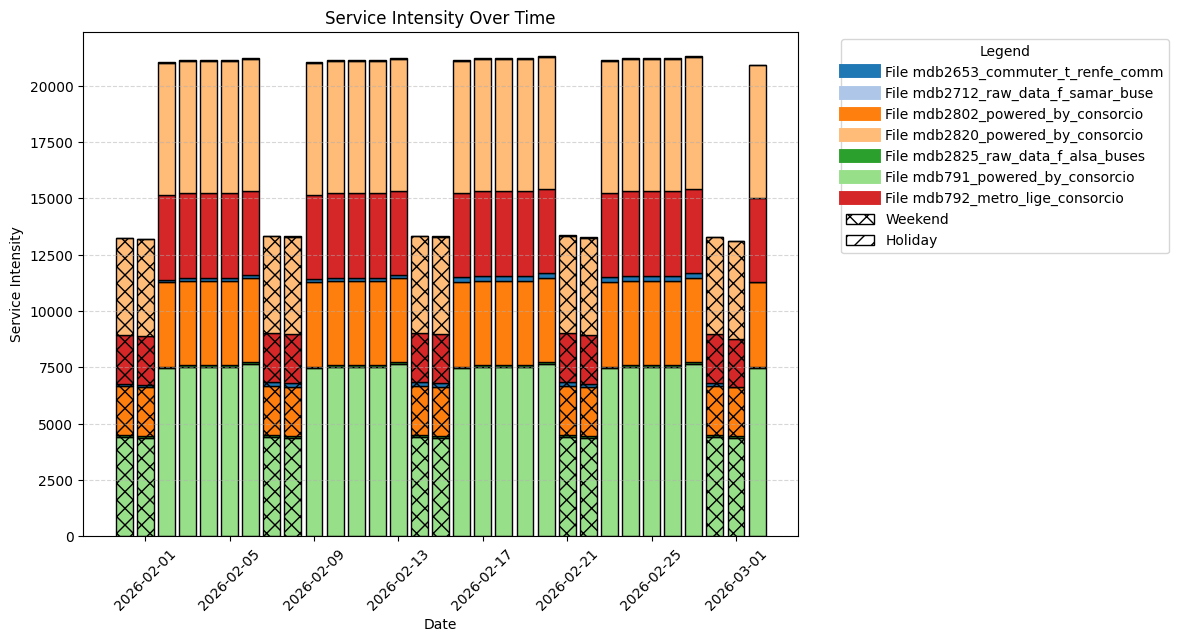

In [22]:
service_intensity = gtfs.get_service_intensity_in_date_range(
    start_date=None, # If None take the feed min date
    end_date=None, # If None take the feed max date
    date_type=None, # Could be something like 'holiday', 'weekday', or 'monday' to only consider some dates from the range.
    by_feed=True
)
service_intensity = service_intensity.to_pandas()
plot_helper.service_intensity(service_intensity)

Select the most representative business day in a date range

In [23]:
idx = processing_helper.most_frequent_row_index(service_intensity)
selected_day = service_intensity.iloc[idx]['date'].to_pydatetime()
selected_day

datetime.datetime(2026, 2, 3, 0, 0)

### 3.3 Average speed

Compute the average speed at stops.
To compute speed distance is meassured at a fixed time difference of 'time_step' min from each stop

In [24]:
# Filter by the selected day and time bounds
gtfs_lf = gtfs.filter(
        date=selected_day,
        start_time=start_time,
        end_time=end_time,
        frequencies=False,
)
speed_by = "trip_id" 
stop_speed_lf = gtfs.get_mean_speed_at_stops(
    date=selected_day,
    start_time=start_time,
    end_time=end_time,
    route_types = 'all',
    by = speed_by, # Speed is computed for every 'trip_id' and grouped by this column with the how method
    at = stop_id, # Compute speed for every 'parent_station' 'stop_id' or 'route_id'
    how="mean", # How to group individual trip speeds 'mean' 'max' or 'min'
    direction='both', # Compute speed in 'forward' 'backward' or 'both' directions (walking n_stops in direction)
    time_step=15, # Minutes required to meassure the speed
)
if isinstance(stop_speed_lf,pl.DataFrame):
    stop_speed_lf = stop_speed_lf.lazy()

gtfs_lf = gtfs_lf.join(stop_speed_lf.select([stop_id,speed_by,'speed']),on=[stop_id,speed_by],how='left')

/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/pyGTFSHandler/feed.py:1949: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided
  return gtfs_lf.filter(pl.col("isin_aoi") == True).drop("isin_aoi").collect()
sys:1: UserWarning: Sortedness of columns cannot be checked when 'by' groups provided


In [25]:
# Group to speeds per stop and mode (or route_type) 
best_stop_speed_lf = gtfs_lf.group_by(list(np.unique(["route_type", stop_id]))).agg(
    pl.col("route_id").unique().alias("route_ids"),
    (
        (pl.col("speed").abs() * pl.col("n_trips")).sum()
        / pl.col("n_trips").sum()
    ).alias("speed"),
    pl.col("n_trips").sum().alias("n_trips"),
    pl.col("isin_aoi").any().alias("isin_aoi")
).sort("speed")
# Plot everythng on a map
best_stop_speed_df = best_stop_speed_lf.collect().to_pandas()
best_stop_speed_df = gtfs.add_stop_coords(best_stop_speed_df)
best_stop_speed_df = gtfs.add_route_names(best_stop_speed_df)
best_stop_speed_df = gpd.GeoDataFrame(
    best_stop_speed_df,
    geometry=gpd.points_from_xy(best_stop_speed_df['stop_lon'],y=best_stop_speed_df['stop_lat']),
    crs=4326
)
m = plot_helpers.general_map(
    aoi=aoi,
    pois=best_stop_speed_df,
    poi_cmap="RdYlGn",
    poi_column="speed",
)
#m.save(city_results_path+"/stop_speed_map.html")
m

### 3.4 Average waiting time (interval) at stops

Interval is in *minutes*

In this example we use the *shape_direction* mode 

- Uses direction (shape_direction) in degrees from north that every 'trip_id' is pointing to computed at every stop and every trip
- Creates 'n_divisions' * 2 groups (*2 to get outbound and inbound directions independently) by clustering the trip shape directions 
- If how = 'best' means the interval is computed only for the best of all divisions at every stop 

In [27]:
stop_interval_df = []
for mode in mode_grid:
    gtfs_selection = gtfs._filter_by_route_type(
        gtfs_lf,
        route_types=simplified_route_type_mapping[mode]
    )
    gtfs_length = (
        gtfs_selection
        .select(pl.len())
        .collect()
        .item()
    )
    if gtfs_length == 0:
        continue 

    for i in range(len(speed_grid)-1):
        gtfs_selection = gtfs_selection.filter(
            (pl.col("speed") >= speed_grid[i])
        )
        gtfs_length_i = (
            gtfs_selection
            .select(pl.len())
            .collect()
            .item()
        )
        if gtfs_length_i == gtfs_length:
            continue 
        if gtfs_length_i == 0:
            continue 

        gtfs_length = gtfs_length_i
        df = gtfs._get_mean_interval_at_stops(
                gtfs_selection,
                date=selected_day,
                start_time=start_time,
                end_time=end_time,
                by = "shape_direction", # Interval is computed for all 'trip_id' grouped by this column and sorted by 'departure_time'
                at = stop_id, # Where to compute the interval 'stop_id' 'parent_station'
                how = "best", 
                # 'best' pick the route with best interval, 
                # 'mean' Combine all intervals of all routes, 
                # 'all' return results per stop and route
                n_divisions=1, # Number of divisions for by = 'shape_direction'
        ).with_columns(
            pl.lit(mode).alias("mode"),
            pl.lit(speed_grid[i+1]).alias("speed_grid")
        )
        stop_interval_df.append(df)

stop_interval_df = (
    pl.concat(stop_interval_df)
).to_pandas()
stop_interval_df["interval_grid"] = np.array(interval_grid)[
    np.searchsorted(np.array(interval_grid), stop_interval_df["mean_interval"], side="left")
]
stop_interval_df = gtfs.add_stop_coords(stop_interval_df)
stop_interval_df = gtfs.add_route_names(stop_interval_df)
stop_interval_df = gpd.GeoDataFrame(
    stop_interval_df,
    geometry=gpd.points_from_xy(stop_interval_df['stop_lon'],y=stop_interval_df['stop_lat']),
    crs=4326
)
stop_interval_df = stop_interval_df[stop_interval_df.geometry.is_valid]
stop_interval_df["service_quality"] = stop_interval_df.apply(
    lambda row: stop_quality(
        row["mean_interval"],
        row["mode"],
        row["speed_grid"],
    ),
    axis=1
)
stop_interval_df["service_quality_grid"] = stop_interval_df.apply(
    lambda row: stop_quality(
        row["interval_grid"],
        row["mode"],
        row["speed_grid"],
    ),
    axis=1
).round(3)
stop_interval_df = stop_interval_df.sort_values("service_quality").drop_duplicates(stop_id,keep="last")
stop_interval_df = stop_interval_df.sort_values(stop_id).reset_index(drop=True)
stop_interval_df.to_file(os.path.join(city_results_path,"stops.gpkg"))
stop_interval_df

2026-01-31 20:27:22,597 - INFO - Created 96 records


parent_station  shape_direction  \
0   0000614300000001_file_0       167.135570   
1   0000614300000002_file_0        27.679817   
2          par_10_50_file_1        94.816325   
3          par_10_51_file_1        71.603096   
4          par_10_52_file_1        66.378869   
..                      ...              ...   
91       par_8_18346_file_3        32.146850   
92       par_8_18358_file_3        26.290019   
93       par_8_18647_file_3       205.497670   
94       par_8_19131_file_3        58.495598   
95       par_8_20881_file_3       228.410846   

                                            shape_ids  mean_interval mode  \
0   [1413950_9__3__106_-10159204_file_5, 1413950_9...       8.077730  bus   
1   [1414026_8__464___-10159162_file_3, 1414014_8_...      30.757282  bus   
2   [10_I12-042_2023I12_00:00:00_1_68_10__4_2___fi...       9.675000  bus   
3   [10_I12-042_2023I12_00:00:00_1_68_10__4_2___fi...       8.592130  bus   
4   [10_I12-042_2023I12_00:00:00_1_68_10__4_2___fi...       9.591667  bus   
..                                                ...            ...  ...   
91  [1413950_9__3__106_-10159205_file_5, 1413950_9...      26.373699  bus   
92  [1413972_8__460___-10159543_file_3, 1413970_8_...      31.459963  bus   
93  [1414019_8__463___-10159185_file_3, 1413971_8_...      32.209346  bus   
94                [1413979_8__461___-10159140_file_3]      10.000313  bus   
95  [1413946_9__2__106_-10159720_file_5, 1413949_9...      15.118136  bus   

    speed_grid  interval_grid   stop_lat  stop_lon  \
0      23.1250       9.204102  40.242002 -3.769704   
1      23.1250      38.632812  40.246700 -3.767085   
2      23.1250      10.605469  40.244100 -3.757560   
3      23.1250       9.204102  40.245339 -3.762497   
4      23.1250      10.605469  40.245990 -3.766350   
..         ...            ...        ...       ...   
91     23.1250      27.421875  40.225458 -3.759592   
92     23.1250      38.632812  40.241292 -3.778971   
93     23.1250      38.632812  40.245864 -3.767567   
94     23.1250      10.605469  40.231735 -3.771268   
95     14.0625      16.210938  40.245117 -3.784141   

                                 stop_name     route_short_names  \
0                                    Parla         [461, 471, 3]   
1                                    Parla  [464, 463, 462, 460]   
2                           PLAZA_DE_TOROS                 [ML4]   
3                   JULIO_ROMERO_DE_TORRES            [469, ML4]   
4                               LA_BALLENA                 [ML4]   
..                                     ...                   ...   
91        AV.SISTEMA_SOLAR-PLANETA_SATURNO                   [3]   
92                AV.RONDA-CENTRO_INFANTIL       [466, 460, 463]   
93                     REAL-EST.LA_BALLENA       [460, 466, 463]   
94  AV.JUAN_CARLOS_I-FERNANDO_III_EL_SANTO                 [461]   
95                             par_8_20881                [2, 3]   

                                     route_long_names           route_names  \
0   [HUMANES-FUENLABRADA-PARLA-PINTO, HOSPITAL-AVE...         [461, 471, 3]   
1   [MADRID_(Plaza_Eliptica)-PARLA-YUNCLILLOS, MAD...  [463, 460, 464, 462]   
2                 [Tranvia_de_Parla_(Linea_Circular)]                 [ML4]   
3   [Tranvia_de_Parla_(Linea_Circular), MADRID_(Pl...            [ML4, 469]   
4                 [Tranvia_de_Parla_(Linea_Circular)]                 [ML4]   
..                                                ...                   ...   
91          [HOSPITAL-AVENIDA_DE_AMeRICA-LAGUNA_PARK]                   [3]   
92  [PARLA-VALDEMORO, MADRID_(Plaza_Eliptica)-PARL...       [463, 460, 466]   
93  [MADRID_(Plaza_Eliptica)-PARLA-BATRES, MADRID_...       [463, 466, 460]   
94                    [MADRID_(Plaza_Eliptica)-PARLA]                 [461]   
95  [CIRCULAR_2, HOSPITAL-AVENIDA_DE_AMeRICA-LAGUN...                [3, 2]   

                                            route_ids route_types  \
0   [8__461____file_3, 8__4

In [28]:
m = plot_helpers.general_map(
    aoi=aoi,
    pois=stop_interval_df,
    poi_cmap="Blues",
    poi_column="service_quality",
)
m.save(city_results_path+"/stop_quality_map.html")
m

## 4 Street graph

### 4.1 Regionwise file and cropping

- Download best regionwise pbf file. (Covers a large area)

- Crop it to cover our area of interest and save it in .osm format

In [29]:
osm_xml_file = os.path.normpath(city_results_path+f"/streets.osm")
streets_graph_path = os.path.normpath(city_results_path+f"/streets.graphml")
streets_path = os.path.normpath(city_results_path+f"/streets.gpkg")
accessibility_streets_path = os.path.normpath(city_results_path+f"/accessibility_streets.gpkg")
population_results_path = os.path.normpath(city_results_path+f"/population.gpkg")

In [30]:
# Select what type of street network you want to load
network_filter = osm.osmium_network_filter("walk+bike+primary")
# Download the region pbf file crop it by aoi and convert to osm format
osm.geofabrik_to_osm(
    osm_xml_file,
    input_file=results_path,
    aoi=aoi_download,
    osmium_filter_args=network_filter,
    overwrite=False
)

File 'output/parla__spain/streets.osm' already exists. Skipping conversion.


'output/parla__spain/streets.osm'

### 4.2 Load to osmnx

This way the street network is a networkx graph

In [31]:
# Load
G = ox.graph_from_xml(osm_xml_file)
# Project geometry coordinates to UTM system to allow euclidean meassurements in meters (sorry americans)
G = ox.project_graph(G,to_crs=aoi.estimate_utm_crs())
# Save the graph in graphml format to avoid the slow loading process
ox.save_graphml(G,streets_graph_path)

### 4.3 Simplify graph

Edges with length smaler than X meters are deleted and its nodes merged

In [32]:
G = graph_processing.simplify_graph(G,min_edge_length=min_edge_length,min_edge_separation=min_edge_length*2,undirected=True)
# Save the result in graphml format
ox.save_graphml(G,streets_graph_path)

street_edges = ox.graph_to_gdfs(G,nodes=False)
street_edges = street_edges.to_crs(aoi.crs)
street_edges.to_file(streets_path)

2026-01-31 20:27:27,515 - INFO - Created 3,475 records


### 4.4 Add Points of interest to graph

In [33]:
G, osmids = graph_processing.add_points_to_graph(
    stop_interval_df,
    G,
    max_dist=100+min_edge_length, # Maximum distance from point to graph edge to project the point
    min_edge_length=min_edge_length # Minimum edge length after adding the new nodes
)
stop_interval_df['osmid'] = osmids # Add the ids of the nodes in the graph to points

## 5 Compute isochrones

In [34]:
distance_matrix = (
    stop_interval_df
    .apply(
        lambda row: [
            {
                "interval_grid": row["interval_grid"],
                "mode": row["mode"],
                "speed_grid": row["speed_grid"],
                "distance_grid": d,
                "service_quality_grid": row["service_quality_grid"],
                "quality_grid": quality(
                    row["interval_grid"],
                    row["mode"],
                    row["speed_grid"],
                    d
                )
            }
            for d in distance_grid
        ],
        axis=1
    )
)
distance_matrix = (
    distance_matrix
    .explode()
    .apply(pd.Series)
    .drop_duplicates()
    .reset_index(drop=True)
)
quality_grid = np.linspace(0,1,n_accessibility_grades+1)
distance_matrix['quality_grid'] = quality_grid[
    np.searchsorted(quality_grid, distance_matrix['quality_grid'], side="left")
]
distance_matrix['quality_grid'] = distance_matrix['quality_grid'].round(3)
distance_matrix = (
    distance_matrix
    .pivot(
        index="service_quality_grid",
        columns="distance_grid",
        values="quality_grid"
    )
    .reset_index()
)
distance_matrix = distance_matrix.rename(columns={"service_quality_grid":"service_quality"})
distance_matrix

distance_grid  service_quality  100.0  129.6875  159.375  218.75  337.5  \
0                        0.293    0.4       0.4      0.4     0.3    0.3   
1                        0.325    0.4       0.4      0.4     0.4    0.3   
2                        0.369    0.4       0.4      0.4     0.4    0.4   
3                        0.425    0.5       0.5      0.5     0.4    0.4   
4                        0.463    0.5       0.5      0.5     0.5    0.4   
5                        0.466    0.5       0.5      0.5     0.5    0.4   
6                        0.468    0.5       0.5      0.5     0.5    0.4   
7                        0.508    0.6       0.6      0.5     0.5    0.5   
8                        0.527    0.6       0.6      0.6     0.5    0.5   
9                        0.565    0.6       0.6      0.6     0.6    0.5   
10                       0.572    0.6       0.6      0.6     0.6    0.5   
11                       0.604    0.7       0.6      0.6     0.6    0.5   
12                       0.677    0.7       0.7      0.7     0.6    0.6   
13                       0.688    0.8       0.7      0.7     0.7    0.6   
14                       0.734    0.8       0.8      0.7     0.7    0.6   
15                       0.770    0.8       0.8      0.8     0.7    0.7   
16                       0.778    0.8       0.8      0.8     0.7    0.7   
17                       0.814    0.9       0.8      0.8     0.8    0.7   

distance_grid  456.25  575.0  812.5  1050.0  1525.0  2000.0  
0                 0.3    0.3    0.3     0.3     0.3     0.3  
1                 0.3    0.3    0.3     0.3     0.3     0.3  
2                 0.4    0.3    0.3     0.3     0.3     0.3  
3                 0.4    0.4    0.4     0.4     0.3     0.3  
4                 0.4    0.4    0.4     0.4     0.4     0.3  
5                 0.4    0.4    0.4     0.4     0.4     0.3  
6                 0.4    0.4    0.4     0.4     0.4     0.3  
7                 0.5    0.4    0.4     0.4     0.4     0.4  
8                 0.5    0.5    0.4     0.4     0.4     0.4  
9                 0.5    0.5    0.5     0.4     0.4     0.4  
10                0.5    0.5    0.5     0.4     0.4     0.4  
11                0.5    0.5    0.5     0.5     0.4     0.4  
12                0.6    0.6    0.5     0.5     0.5     0.5  
13                0.6    0.6    0.5     0.5     0.5     0.5  
14                0.6    0.6    0.6     0.5     0.5     0.5  
15                0.6    0.6    0.6     0.6     0.5     0.5  
16                0.6    0.6    0.6     0.6     0.5     0.5  
17                0.7    0.6    0.6     0.6     0.5     0.5

### 5.1 Isochrones

In [35]:
accessibility_graph = isochrones.graph(
    G,
    stop_interval_df,
    distance_matrix,
    service_quality_col = 'service_quality_grid', # If all points have the same quality this could be None
    min_edge_length = min_edge_length # Do not add new nodes if there will be an edge with less than this length
)
# Save edges as gpkg
accessibility_nodes, accessibility_edges = ox.graph_to_gdfs(accessibility_graph)
accessibility_edges.to_file(accessibility_streets_path)

100%|██████████| 30/30 [00:03<00:00,  9.80it/s]
2026-01-31 20:27:31,548 - INFO - Created 4,154 records


#### Lets visualize the results on a map

### 5.2 Convert to H3

In [36]:
access_h3_df = h3_utils.from_gdf(
    accessibility_edges,
    resolution=h3_resolution,
    columns=['accessibility'],
    contain="overlap",
    method="max",
    buffer=10
)

access_h3_df

accessibility
h3_cell                      
8a390c14d227fff           0.5
8a390c14d237fff           0.5
8a390c14d247fff           0.5
8a390c14d257fff           0.5
8a390c14d25ffff           0.5
...                       ...
8a390cb9b6cffff           0.3
8a390cb9b6d7fff           0.5
8a390cb9b6e7fff           0.3
8a390cb9b6effff           0.3
8a390cb9b6f7fff           0.3

[1395 rows x 1 columns]

In [37]:
m = plot_helpers.general_map(
    aoi=aoi,
    pois=stop_interval_df,
    gdfs=[access_h3_df,accessibility_edges],
    cmap="RdYlGn",
    column="accessibility",
    poi_cmap="Blues",
    poi_column="service_quality"
)
m.save(city_results_path+"/access_map.html")
m

## 6 Population

### 6.1 Download Worldpop tif file

- One file for every country
- 100m pixel size
- tif format
- available from 2000 to 2030
- gender and age

In [38]:
population_file = population.download_worldpop_population(
    aoi_download,
    2025,
    folder=results_path,
    resolution="100m",
)

Raster population path output/esp_pop_2025_CN_100m_R2025A_v1.tif exists. Skipping download...


In [39]:
pop_h3_df = h3_utils.from_raster(population_file,aoi=aoi_download,resolution=h3_resolution)
pop_h3_df = pop_h3_df.rename(columns={'value':'population'})

### 6.2 Assign level of service to each population cell

In [40]:
results_h3_df = access_h3_df.merge(pop_h3_df,left_index=True,right_index=True,how='outer')
results_h3_df = h3_utils.to_gdf(results_h3_df).to_crs(aoi.crs)
results_h3_df = results_h3_df[results_h3_df.intersects(aoi.union_all())]
results_h3_df.to_file(population_results_path)
results_h3_df

2026-01-31 20:27:36,796 - INFO - Created 1,520 records


accessibility  population  \
h3_cell                                     
8a390c14da4ffff           0.5         NaN   
8a390c14da5ffff           0.5         NaN   
8a390c14da67fff           NaN    0.017219   
8a390c14da6ffff           0.5    0.022777   
8a390c14db27fff           NaN   15.810202   
...                       ...         ...   
8a390cab6d87fff           0.3    0.000029   
8a390cab6d8ffff           0.3    7.459510   
8a390cab6d9ffff           0.5    0.488091   
8a390cab6da7fff           NaN    0.000058   
8a390cab6daffff           0.4    3.428287   

                                                          geometry  
h3_cell                                                             
8a390c14da4ffff  POLYGON ((433595.849 4451753.669, 433525.751 4...  
8a390c14da5ffff  POLYGON ((433515.144 4451647.576, 433445.045 4...  
8a390c14da67fff  POLYGON ((433417.373 4451903.505, 433347.273 4...  
8a390c14da6ffff  POLYGON ((433546.964 4451881.633, 433476.865 4...  
8a390c14db27fff  POLYGON ((432850.103 4452118.963, 432779.999 4...  
...                                                            ...  
8a390cab6d87fff  POLYGON ((432102.007 4453442.435, 432031.898 4...  
8a390cab6d8ffff  POLYGON ((432231.613 4453420.552, 432161.506 4...  
8a390cab6d9ffff  POLYGON ((432150.896 4453314.461, 432080.788 4...  
8a390cab6da7fff  POLYGON ((432053.117 4453570.409, 431983.008 4...  
8a390cab6daffff  POLYGON ((432182.724 4453548.525, 432112.616 4...  

[1520 rows x 3 columns]

In [41]:
pop_gdf_points = results_h3_df.copy()
pop_gdf_points.geometry = pop_gdf_points.geometry.centroid
pop_gdf_points = pop_gdf_points.dropna(subset=['population'])
pop_gdf_points = pop_gdf_points[pop_gdf_points['population'] > 1]
m = plot_helpers.general_map(
    aoi=aoi,
    pois=stop_interval_df,
    gdfs=pop_gdf_points,
    cmap="RdYlGn",
    column="accessibility",
    size_column="population",
    poi_column="service_quality",
    poi_cmap="Blues",
)
m.save(city_results_path+"/population_map.html")
m

### Basic statistics

In [42]:
stats_df = results_h3_df.groupby('accessibility', as_index=False)['population'].sum()
stats_df = stats_df.sort_values("accessibility",ascending=False)
total_population = stats_df['population'].sum()
stats_df = pd.concat([stats_df, pd.DataFrame([{'accessibility': 'total population', 'population': total_population}])], ignore_index=True)
stats_df['population %'] = (stats_df['population'] * 100 / total_population).round(2)
stats_df['population'] = stats_df['population'].round(0).astype(int)
stats_df.to_csv(city_results_path + "/stats.csv")
stats_df

accessibility  population  population %
0               0.9         294          0.22
1               0.8       56161         42.09
2               0.7       30555         22.90
3               0.6       43424         32.54
4               0.5        2789          2.09
5               0.4         121          0.09
6               0.3          87          0.06
7  total population      133432        100.00

In [43]:
# !zip -r /content/output.zip "{results_path}" # For colab. Export the output folder as zip.

Important files:

- streets.gpkg Has the street geometry as lines (all streets)
- accessibility_streets.gpkg Has the street geometry as lines with the level of service (only streets with level of service)
- population.gpkg Is a grid with population and level of service
- stats.csv Population statistics